##### Copyright 2021 The TF-Agents Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Treinando DQN com TF-Agents

(tutorial disponível no site do tensorflow)

## Introdução


Este é um exemplo retirado do tutorial do TensorFlow sobre TF-Agents, mais especificamente um agente que utiliza o algoritmo DQN para seu aprendizado. 

Neste ambiente, também chamado de pendulo invertido, temos uma base onde um carrinho está oscilando e seu objetivo é manter de pé (mais especificamente em 90°) uma estaca, aplicando forças em seu ponto de pivô (ponto em lilás). Mais detalhes sobre o problema e seu objetivo podem ser visto neste [video](https://www.youtube.com/watch?v=XiigTGKZfks&t=151s), no qual o agente é um robô desenhado para esta tarefa.



![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)




## imports

In [3]:
# os códigos abaixo podem ser utilizados para instalar as bibliotecas necessárias para o algoritmo
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,231 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 25.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [5]:
# Set up a virtual display for rendering OpenAI gym environments.
#configurando um display virtual para renderização do ambiente
#renderizações são utilizadas para visualização do ambiente, que neste caso vai utilizar imagens
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparametros

In [6]:
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Ambiente

O ambiente engloba a tarefa a ser executada pelo agente. O ambiente CartPole está disponível pela biblioteca OpenAI Gym, juntamente com todas as regras de funcionamento e obtenção de recompensas. Todo o código é aberto e pode ser visualizado [aqui](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py). Oa ambientes também podem ser criados manualmente é necessário definir variáveis para os componentes de ação, observação, estado atual, entre outras características intrínsecas do problema. 

In [7]:
#instanciando o ambiente a partir do OpenAI Gym
#usada principalmente para testar algumas variáveis
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

No ambiente CartPole têm programadas as seguintes definições:

-   `observation` é um array que contém posição e velocidade do carrinho e ângulo e velocidade da estaca: 
-   `reward` (decimal)
-   `action` é possível se mover para a direita (1) ou para esquerda (0)


A seguir temos alguns conceitos específicos de programação:

O método `environment.step` recebe uma `action` no ambiente e retorna uma variável tupla `TimeStep` contendo a próxima observação do ambiente e a recompensa para a ação. 

O método `time_step_spec()` retorna a especificação da tupla `TimeStep`. O atributo `observation` e `reward` mostram, respectivamente para a observação e recomppensa, a dimensão, o tipo de dados e os intervalos de valores permitidos.

O método `action_spec()` tem o mesmo princípio que os dois atributos anteriores, sendo aplicado para as ações válidas que podem ser executadas.

Estas variáveis podem ser visualizadas logo abaixo:


In [8]:
#código apenas para observação das variáveis
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [9]:
#aqui também exibimos as variáveis que utilizaremos no programa
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.01291545,  0.02529117, -0.01004097,  0.04813481], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.01342128,  0.22055565, -0.00907827, -0.24769914], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


Geralmente se utiliza dois ambientes, um para treinamento e outro para avaliação, onde será utilizada uma política aleatória para analisar o aprendizado do agente (seção de avaliação).  

In [10]:
#instanciando os ambientes que iremos usar
train_py_env = suite_gym.load(env_name) #ambiente de treinamento
eval_py_env = suite_gym.load(env_name)  #ambiente de avaliação

#os ambientes devem ser convertidos para tf_environment para serem usados no TensorFlow
#isso também otimiza o desempenho de alguns algoritmos e facilita a paralelização
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agente

Este agente e composto por uma rede neural profunda que aproxima o comportamento de uma tabela Q de valores ação-observação. Esta rede neural é escrita aqui utilizando uma rede neural densa (redes com muitos neurônios), que tem na primeira camada 100 neurônios e 50 na segunda.

Além da rede DQN, o agente também é composto por um otimizador e uma função de perda, além de outras propriedades necessárias. O algoritmo de otimização é utilizado por diversos tipos de agentes e, neste caso, o algoritmo Adam (Adaptive Moment Estimation) é uma vriação do algoritmo SGD (Descida de Gradiente Estocástico)

In [11]:
fc_layer_params = (100, 50) #rede com duas camadas densas
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

#função para criação das camadas densas da rede neural
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu, #função de ativação Rectified Linear Unit
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))
  
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

#camada de saída
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# uma QNetwork já tem configurações e instruções de como ser insanciada no tensorflow
# aqui geramos duas camadas densas, seguidas por uma camada (densa) de saída 
# com o numero de neuronios suficiente para cada possivel ação
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [12]:
#função de otimização da rede neural
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

#declaração do agente
#já existe uma função no tensorflow que cuida em instanciar esse agente
#bastando apenas passar os parâmetros
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

#inicialização
agent.initialize()

## Politicas

Uma política é uma função que define qual ação o agente deve tomar naquele momento, no caso, escolher entre esquerda e direita de forma que a estaca continue em 90° (ou o mais próximo disso). Um agente DQN é off-policy, o que significa que o agente não depende inicialmente da política, mas irá aprender até que a política possa entregar a ação ideal.


In [13]:
#para avaliação e implantação o código utiliza agent.policy
#usada para coleta de dados
collect_policy = agent.collect_policy

Exatamente por ser off-policy, a política pode ser criada independente da implementação do agente, como o caso abaixo que cria uma política que escolhe as ações aleatoriamente. Ações podem ser executadas utilizando `random_policy.action(time_step)`

In [14]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Métricas e Avaliação

A métrica mais comum é o retorno médio, que consiste em calcular a média das recomepensas totais de cada episódio. A função abaixo calcula o retorno médio para uma política, dependendo também do ambiente e do número de episódios a serem avaliados.


In [15]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

#executando uma avaliação para a política aleatória como exemplo
compute_avg_return(eval_env, random_policy, num_eval_episodes)

20.2

## Buffer de Repetição (Replay Buffer)

O buffer de repetição também é um aprimoramento feito na construção do algoritmo DQN. Estaremos utilizando aqui o Reverb, criado pela DeepMind, para abstrair parte das funções que precisaremos. Em resumo, são armazenados alguns dados de experiências utilizando o `agent.collect_data_spec`, que são reprocessados um pouco mais tarde dentro do próprio treinamento, funcionando a grosso modo como uma "recordação de experimentos passados", o que refina o aprendizado. 


In [16]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec, # também chamda de trajetória em outros agentes
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [17]:
#exibição dos campos que são passados do agente para o buffer
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Coleta de dados

Primeiramente, para coletar dados, será executado alguns passos de uma política aleatória sobre o ambiente. A execução utiliza a biblioteca PyDriver, que abstrai os loops que precisam ser realizados sobre os tensores e retorna uma tupla contendo a observação do ambiente, a ação recomendada pela política, a recompensa obtida, o próximo passo, etc.

In [18]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.05744642,  0.43299198, -0.0279317 , -0.7563798 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)}),
 ())

O replay buffer se torna então uma coleção de trajetórias retornadas pelo PyDriver

In [19]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
{'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>,
 'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>,
 'observation': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.17322691, -0.811593  ,  0.16450898,  1.4811593 ],
       [-0.18945877, -1.0082953 ,  0.19413216,  1.8203771 ]],
      dtype=float32)>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([3434194001552483641, 3434194001552483641], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=

O agente então acessa o buffer através do `tf.data.Dataset` e realimenta seus dados. Cada linha do buffer de repetição armazena apenas uma única etapa de observação. Para calcular a perda, é necessário a observação atual e a seguinte, então são enviadas duas linhas adjacentes para cada item no batch. (`num_steps=2`). 

In [20]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset #exibição

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None)))>

In [21]:
iterator = iter(dataset)
print(iterator)

## Treinando o Agente

Durante a etapa de treinamento, são coletados dados do ambiente e estes são usados para treinar a rede neural do agente. De tempos em tempos, é realizada uma avaliação da política.

In [22]:
#@test {"skip": true}

# função opcional que utiliza grafos para otimizar o desempenho
agent.train = common.function(agent.train)

# resetando a contagem de passos 
agent.train_step_counter.assign(0)

# Avaliando a política antes do treinamento
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Resetando o ambiente
time_step = train_py_env.reset()

# Criando o driver de coleta de experiências
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # coleta alguns passos e salva no buffer
  time_step, _ = collect_driver.run(time_step)

  # Separa uma amostra (batch de dados) do buffer para atualizar a rede neural
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  #exibição do passo atual e do calculo do retorno médio
  step = agent.train_step_counter.numpy()
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 24.965190887451172
step = 400: loss = 23.222728729248047
step = 600: loss = 134.9763641357422
step = 800: loss = 129.24383544921875
step = 1000: loss = 108.97207641601562
step = 1000: Average Return = 36.400001525878906
step = 1200: loss = 801.1943969726562
step = 1400: loss = 337.843017578125
step = 1600: loss = 140.77223205566406
step = 1800: loss = 399.42828369140625
step = 2000: loss = 51.072532653808594
step = 2000: Average Return = 196.3000030517578
step = 2200: loss = 939.460205078125
step = 2400: loss = 9708.267578125
step = 2600: loss = 175.13369750976562
step = 2800: loss = 553.893310546875
step = 3000: loss = 632.397705078125
step = 3000: Average Return = 200.0
step = 3200: loss = 988.0794677734375
step = 3400: loss = 1499.541

## Visualização Final


### Gráfico da avaliação

Este gráfico foi criado usando a biblioteca `matplotlib.pyplot`, onde é mostrada a evolução da política durante o treinamento do agente. É comum existirem picos e taxas de queda durante o processamento, mas o esperado é que em dado momento exista uma convergência em um valor ótimo.

Uma iteração deste ambiente consiste na execução de 200 time_steps. Oambiente recompensa em +1 para cada passo onde a estaca está em pé, então o retorno máximo possível para cada episódio é 200.

(-0.025000000000000355, 250.0)

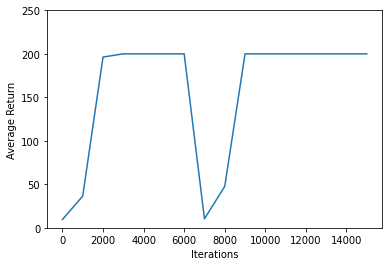

In [23]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Em ambientes que podem ser exibidos em imagens, é possível salvar frames e criar um video. Isso é opicional, mas o código é passado logo abaixo

In [24]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [25]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

Para comparação, é exibido também um video do agente utilizando uma política aleatória, sem nenhum aprendizado

In [26]:
create_policy_eval_video(random_policy, "random-agent")